# Binary Classification of Machine Failures

optimizing ROC AUC instead of PR AUC

## Index <a id="index"></a>

- [Libraries](#libraries)
- [Import Data](#import_data)
- [Data Cleaning](#data_cleaning)
- [Exploratory Data Analysis](#eda)
- [Preprocessing](#preprocessing)
- [PCA Analysis](#pca)
- [Model](#model)
- [Save Predictions](#savepreds)

## Libraries <a id="libraries"></a>

[Return to Index](#index)

In [2]:
import os

In [3]:
if 'source' not in os.listdir():
    os.chdir('..')

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from source.model_toolkit import models as mods
import tensorflow as tf
from scikeras.wrappers import KerasClassifier

In [5]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelBinarizer ,LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.multioutput import ClassifierChain
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import StackingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC

In [6]:
import lightgbm as lgb

## Import Data <a id="import_data"></a>

[Return to Index](#index)

In [7]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [8]:
train_data.iloc[:, :20]

,id,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,EState_VSA2,ExactMolWt,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,HallKierAlpha,HeavyAtomMolWt,Kappa3,MaxAbsEStateIndex,MinEStateIndex
0,0,323.390782,9.879918,5.875576,5.875576,4.304757,4.304757,2.754513,1.749203,0.000000,11.938294,222.068080,1.181818,1.727273,2.363636,-0.24,212.163,8.170000,11.922504,0.171585
1,1,273.723798,7.259037,4.441467,5.834958,3.285046,4.485235,2.201375,1.289775,45.135471,0.000000,260.029719,1.346154,2.076923,2.769231,-0.09,247.031,3.201491,10.932338,-4.830450
2,2,521.643822,10.911303,8.527859,11.050864,6.665291,9.519706,5.824822,1.770579,15.645394,6.606882,382.131027,1.085714,1.742857,2.400000,-0.78,354.106,15.033890,11.238048,-5.066255
3,3,567.431166,12.453343,7.089119,12.833709,6.478023,10.978151,7.914542,3.067181,95.639554,0.000000,530.070277,1.162791,1.573770,2.270270,-1.30,506.124,6.724301,11.171170,-5.276575
4,4,112.770735,4.414719,2.866236,2.866236,1.875634,1.875634,1.036450,0.727664,17.980451,12.841643,118.062994,1.444444,2.111111,2.555556,-1.10,108.056,3.931272,9.855741,-1.676296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14833,14833,632.207041,10.911303,6.579933,9.179964,4.653583,6.030052,3.670528,1.770579,32.971529,6.606882,347.063084,1.562500,2.187500,2.687500,-1.87,333.112,4.879408,11.426427,-5.077909
14834,14834,62.568425,2.642734,1.446898,1.446898,0.879497,0.879497,0.174620,0.000000,0.000000,0.000000,74.024203,2.666667,2.666667,2.666667,-0.53,70.027,0.729375,5.506944,0.250000
14835,14835,981.327476,10.363081,6.146219,6.146219,4.700576,4.700576,3.064846,2.133897,17.248535,0.000000,297.089560,1.461538,2.153846,2.769231,-3.15,282.220,2.045502,12.118907,-0.446105
14836,14836,299.171248,9.949161,6.589761,7.848913,5.276568,5.476436,3.978973,2.299833,45.623794,0.000000,265.959270,0.950000,1.400000,1.950000,-0.44,257.119,8.424399,10.909292,-4.181527


In [9]:
train_data.iloc[:, 20:]

,NumHeteroatoms,PEOE_VSA10,PEOE_VSA14,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2,EC1,EC2,EC3,EC4,EC5,EC6
0,4,0.000000,91.536492,0.000000,0.000000,0.000000,17.744066,0.000000,4.794537,35.527357,0,0,1,1,0,0,0,0
1,10,24.415866,7.822697,0.000000,0.000000,0.000000,7.822697,30.705892,13.825658,44.707310,0,0,0,1,1,0,0,0
2,9,0.000000,15.645394,0.000000,53.378235,0.000000,15.645394,73.143616,17.964475,45.660120,0,0,1,1,0,0,1,0
3,19,42.727765,21.335138,0.000000,0.000000,6.420822,15.645394,62.107304,31.961948,87.509997,0,0,1,1,0,0,0,0
4,4,6.041841,11.938611,6.923737,19.386400,0.000000,11.938611,18.883484,9.589074,33.333333,2,2,1,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14833,16,17.248535,15.645394,0.000000,13.847474,6.923737,34.407699,32.607024,18.947452,61.376610,0,0,1,1,0,0,0,0
14834,0,0.000000,0.000000,0.000000,0.000000,6.066367,0.000000,6.420822,0.000000,10.000000,0,0,0,1,0,1,0,0
14835,8,34.480943,0.000000,0.000000,0.000000,23.762553,10.969244,0.000000,0.000000,66.666667,0,0,1,1,0,0,0,0
14836,7,0.000000,7.822697,19.420579,0.000000,0.000000,7.822697,108.961047,9.088795,45.583333,0,0,0,1,1,0,0,0


## Data Cleaning <a id="data_cleaning"></a>

[Return to Index](#index)

In [10]:
pd.isnull(train_data).sum()

id                   0
BertzCT              0
Chi1                 0
Chi1n                0
Chi1v                0
Chi2n                0
Chi2v                0
Chi3v                0
Chi4n                0
EState_VSA1          0
EState_VSA2          0
ExactMolWt           0
FpDensityMorgan1     0
FpDensityMorgan2     0
FpDensityMorgan3     0
HallKierAlpha        0
HeavyAtomMolWt       0
Kappa3               0
MaxAbsEStateIndex    0
MinEStateIndex       0
NumHeteroatoms       0
PEOE_VSA10           0
PEOE_VSA14           0
PEOE_VSA6            0
PEOE_VSA7            0
PEOE_VSA8            0
SMR_VSA10            0
SMR_VSA5             0
SlogP_VSA3           0
VSA_EState9          0
fr_COO               0
fr_COO2              0
EC1                  0
EC2                  0
EC3                  0
EC4                  0
EC5                  0
EC6                  0
dtype: int64

Not much data cleaning to do

## Exploratory Data Analysis <a id="eda"></a>

[Return to Index](#index)

We'll combine EC1 and EC2 to make a single multi-class label

In [11]:
target_vars = ['EC1', 'EC2']

In [12]:
train_data['y'] = train_data.apply(
    lambda x:
    '-'.join([str(int(x[target_var])) for target_var in target_vars]),
    axis = 1
)

Define numerical and categorical columns

In [13]:
exclude_cols = ['id', 'EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6', 'y']
categorical_cols = ['fr_COO', 'fr_COO2']
numerical_cols = [col for col in train_data.columns if col not in exclude_cols + categorical_cols]

### Numerical Columns

In [14]:
def boxplot_bytarget(df, cols, target_var, **kwargs):
    ylabels = df[target_var].unique()
    
    for i in range(len(cols)):
        fig, ax = plt.subplots()
        ax.boxplot([df[df[target_var] == ylabel][cols[i]] for ylabel in ylabels], **kwargs)
        
        ax.set_ylabel(cols[i])
        ax.set_xlabel(target_var)
        
        ax.set_xticklabels(ylabels)
        
        ax.set_title(f'Boxplot of {cols[i]} by {target_var}') 
        plt.show()

In [15]:
def hist_bytarget(df, cols, target_var, **kwargs):
    ylabels = df[target_var].unique()
    
    for i in range(len(cols)):
        fig, ax = plt.subplots()
        for ylabel in ylabels:
            ax.hist(df[df[target_var] == ylabel][cols[i]], label = ylabel, **kwargs)
        
        ax.set_xlabel(cols[i])
        ax.set_ylabel('Relative Frequency')
        
        ax.legend()
        ax.set_title(f'Histogram of {cols[i]} by {target_var}')
        
        plt.show()

In [16]:
def plot_corrmatrix(df, cols):
    data = df[cols].corr()
    
    fig, ax = plt.subplots()
    
    cax = ax.matshow(data)
    
    ax.set_xticks(range(len(numerical_cols)), labels = numerical_cols, rotation = 45)
    ax.set_yticks(range(len(numerical_cols)), labels = numerical_cols)

    for (i, j), value in np.ndenumerate(data):
        ax.text(i, j, f'{round(value, 2)}')
    
    ax.set_title('Correlation Matrix')
    fig.colorbar(cax)
    
    plt.show()

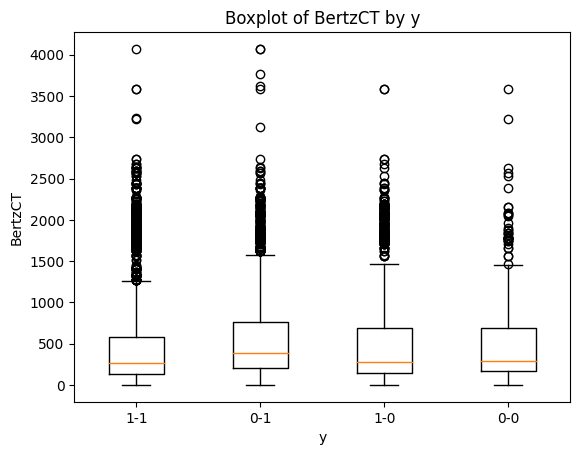

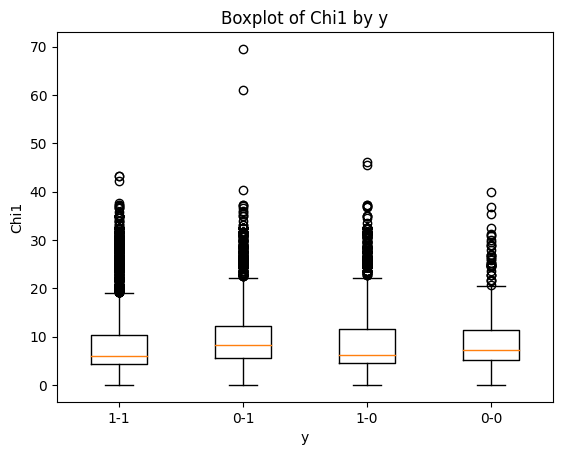

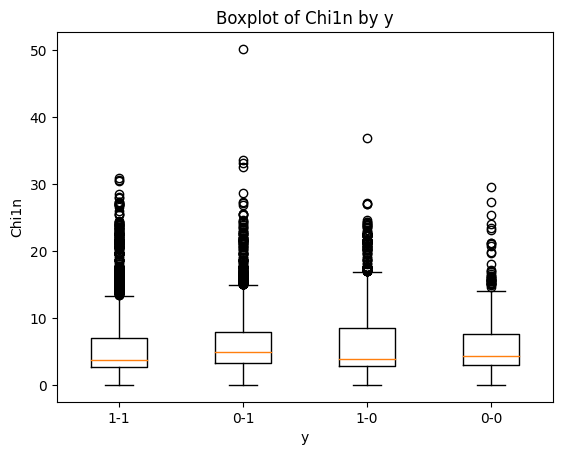

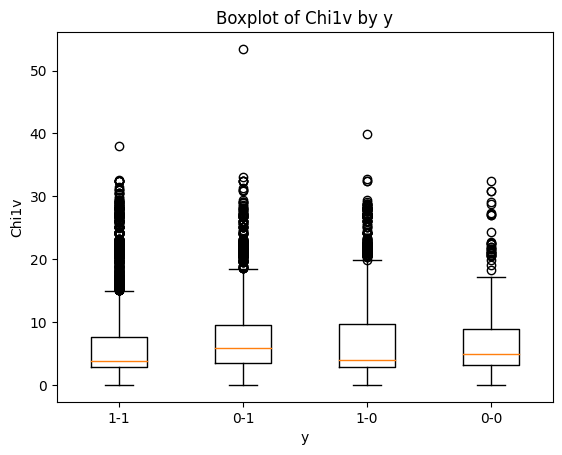

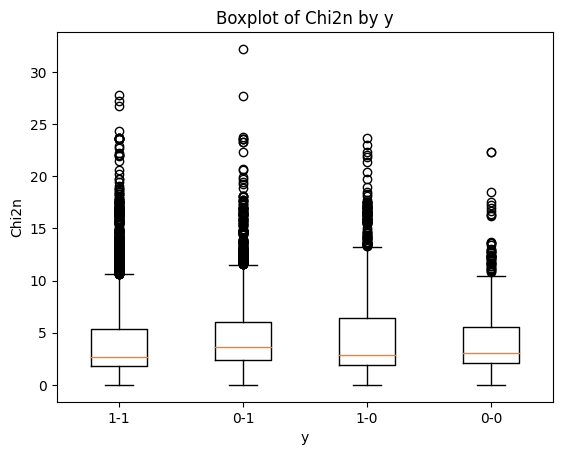

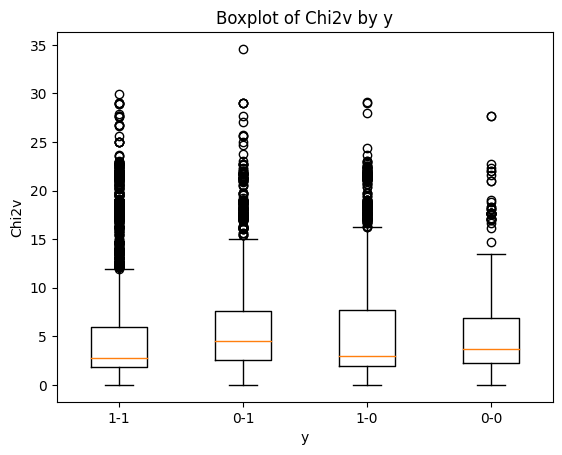

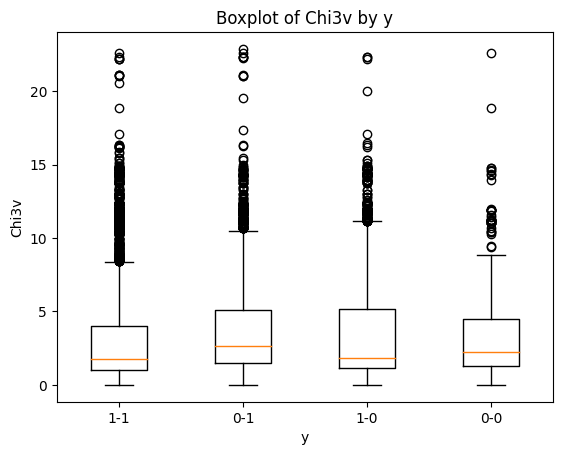

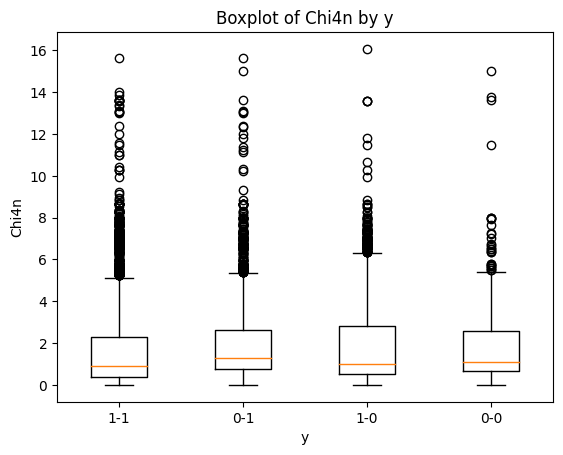

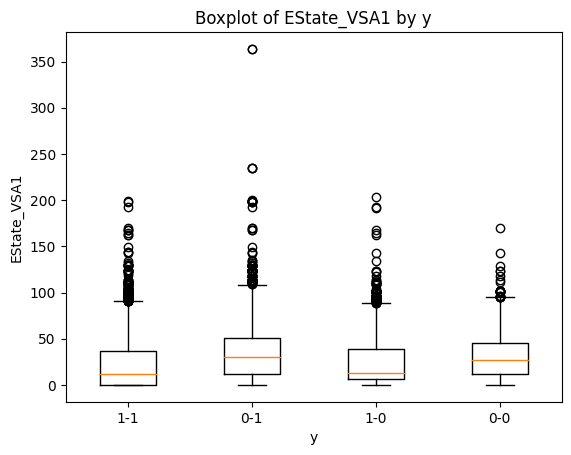

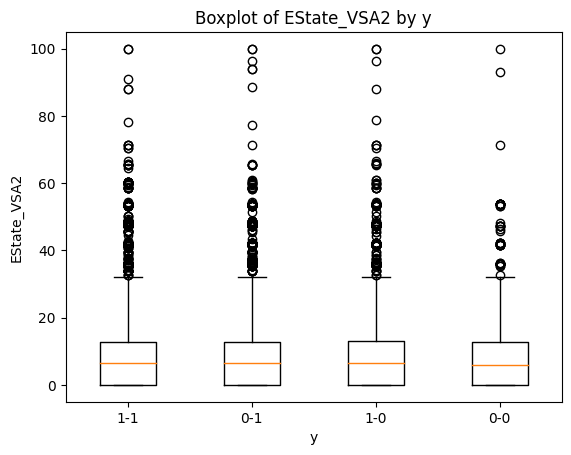

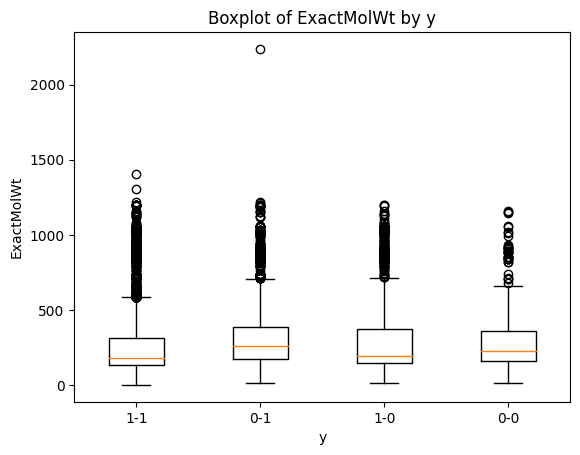

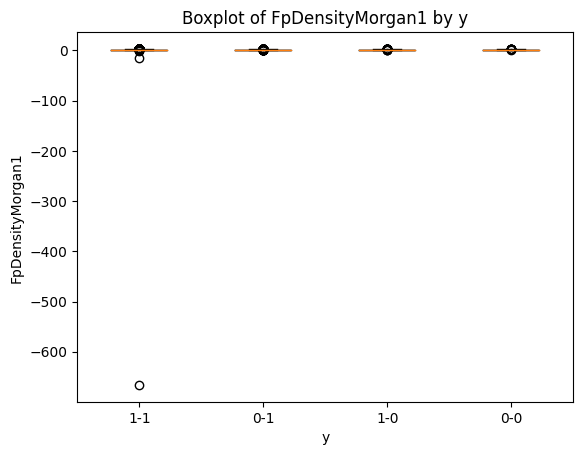

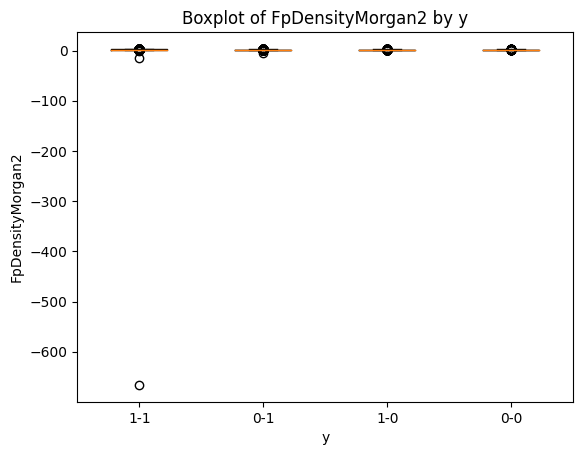

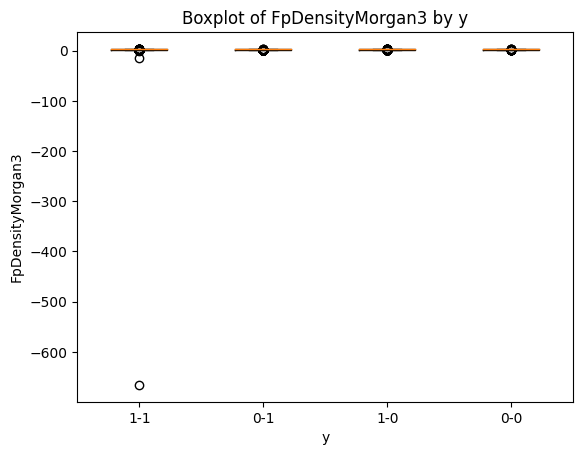

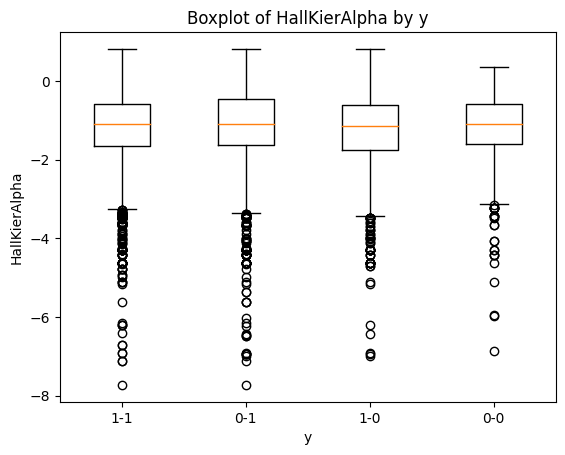

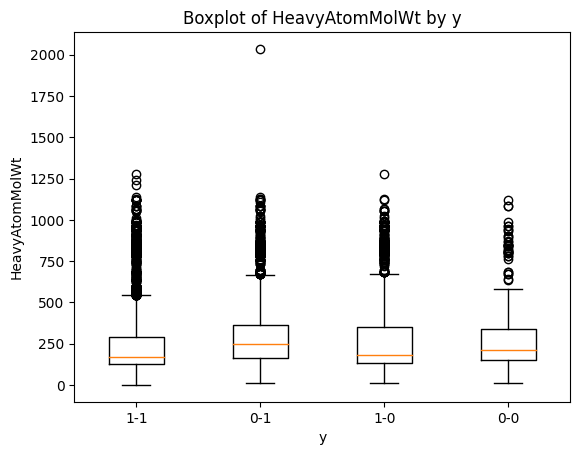

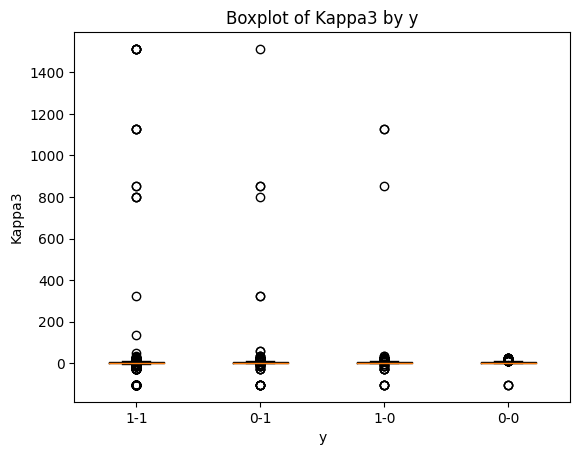

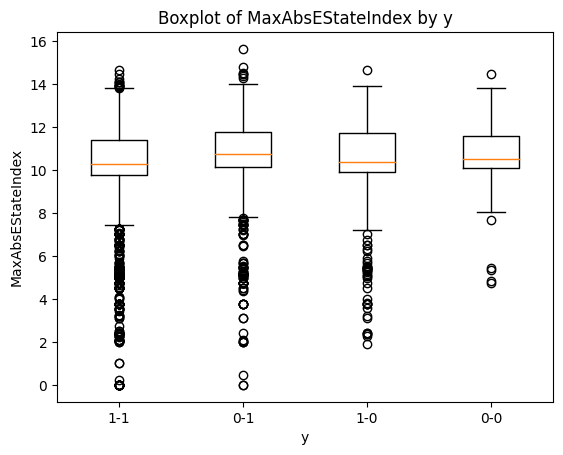

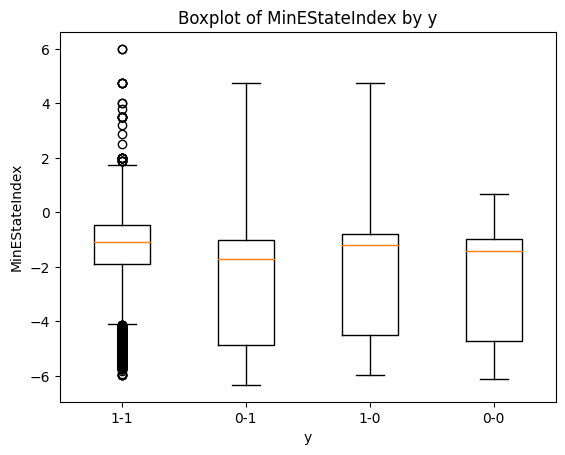

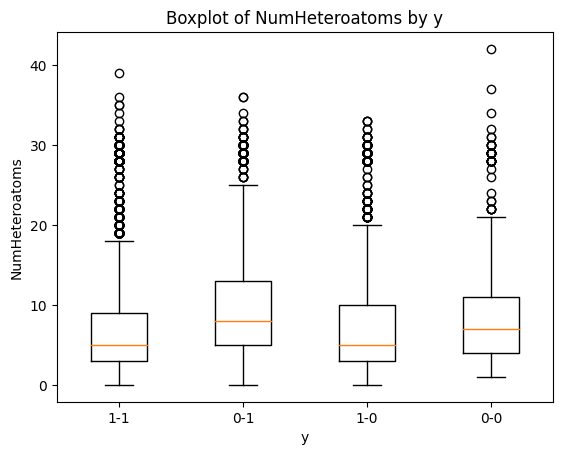

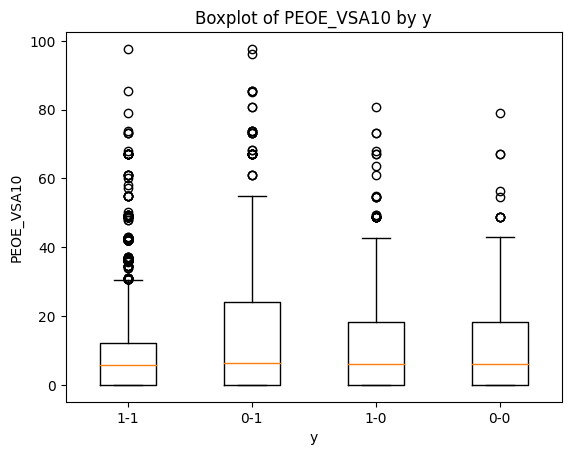

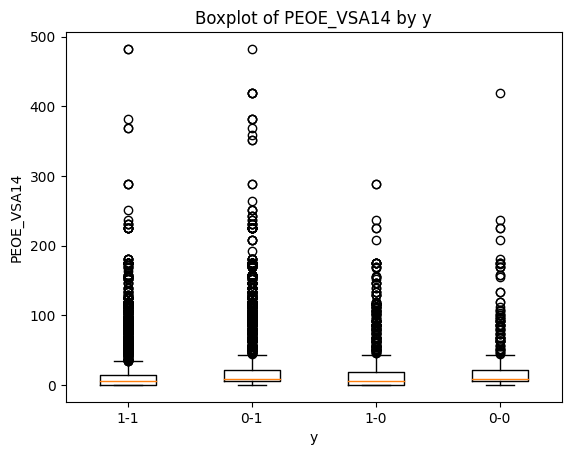

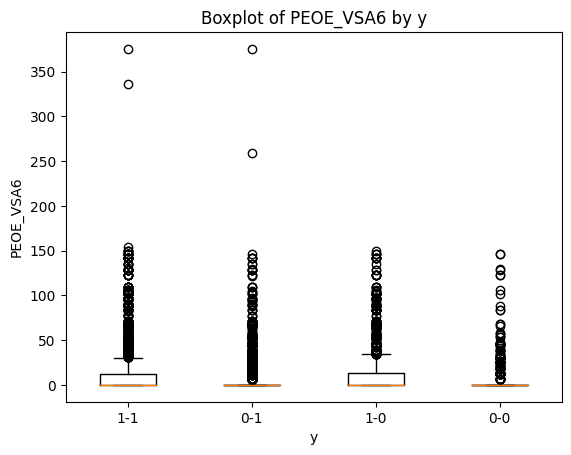

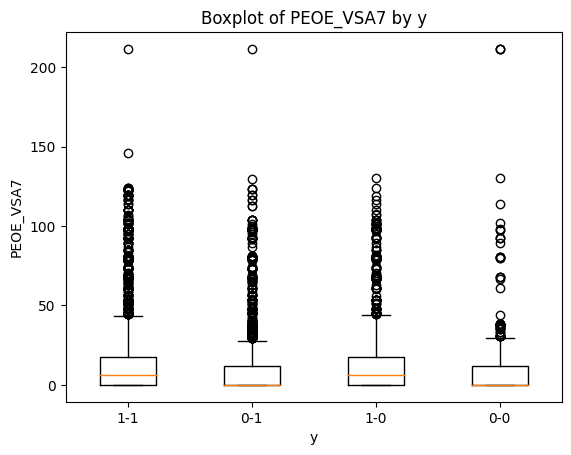

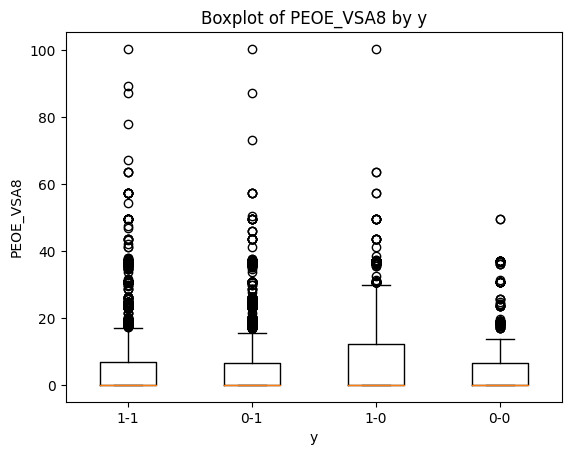

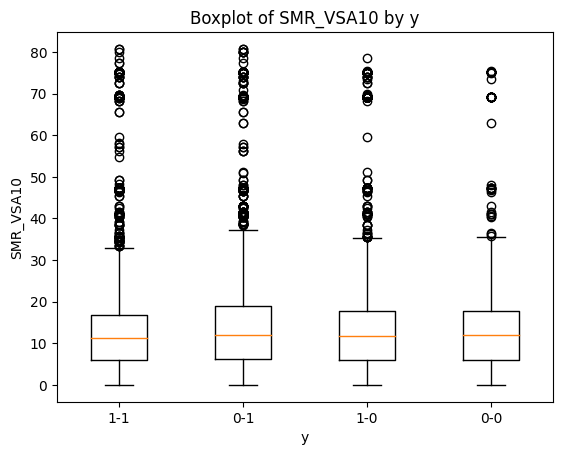

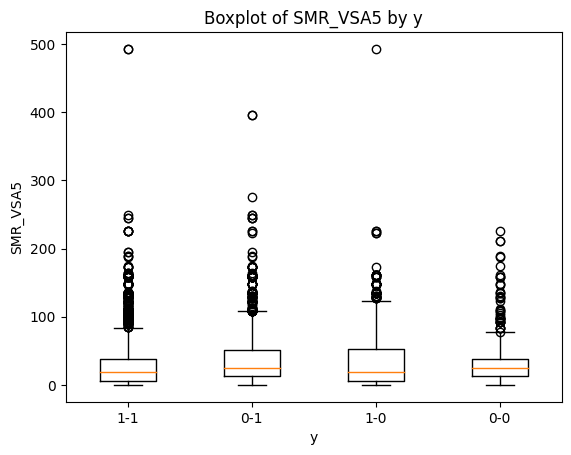

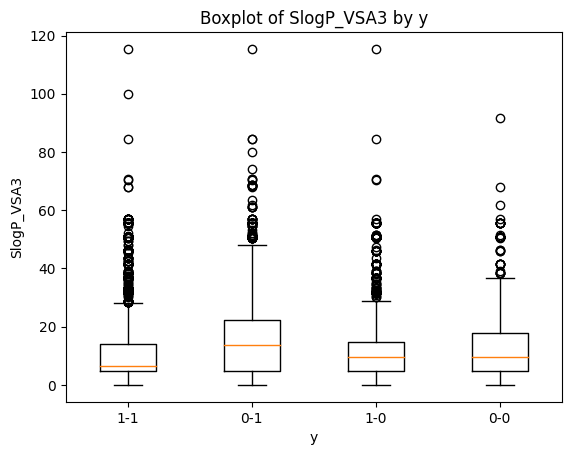

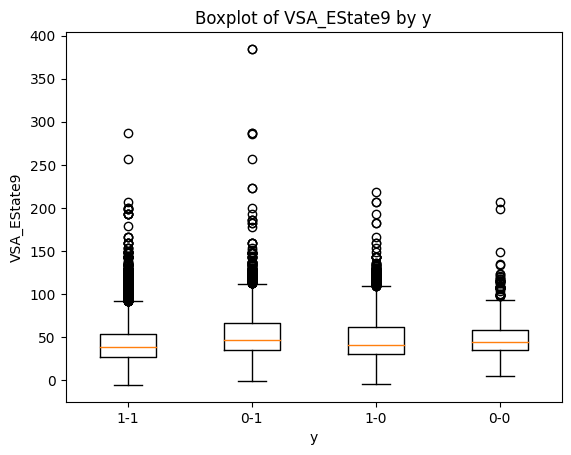

In [17]:
boxplot_bytarget(train_data, numerical_cols, 'y')

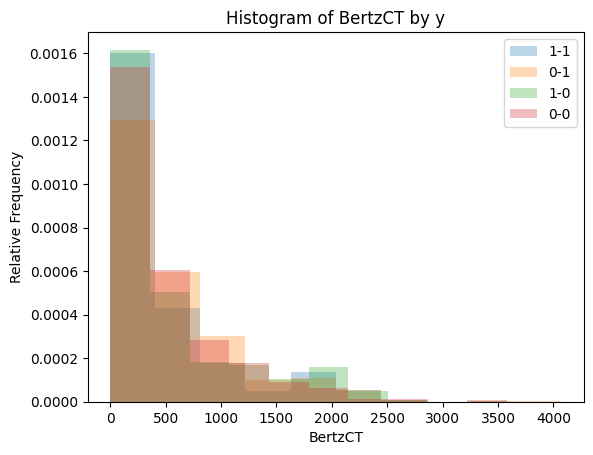

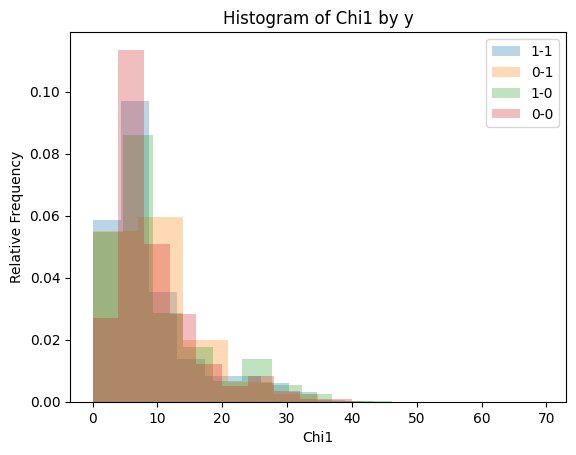

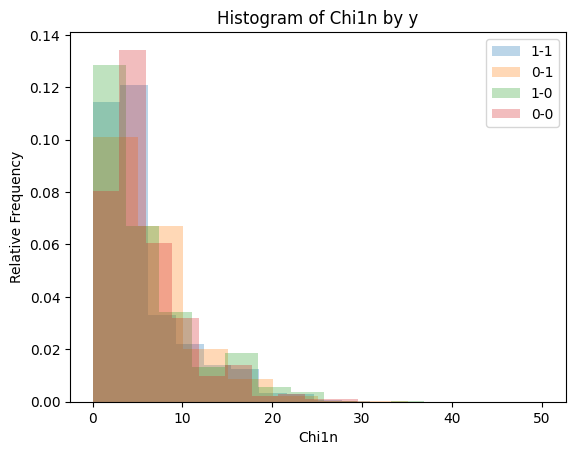

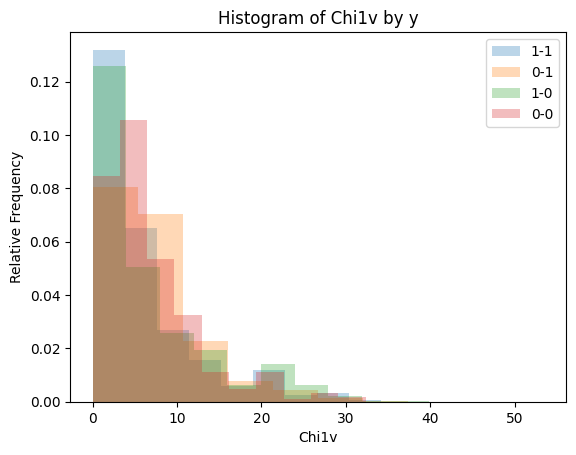

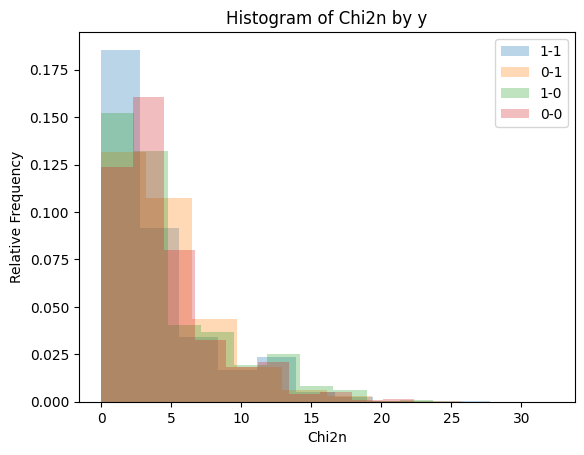

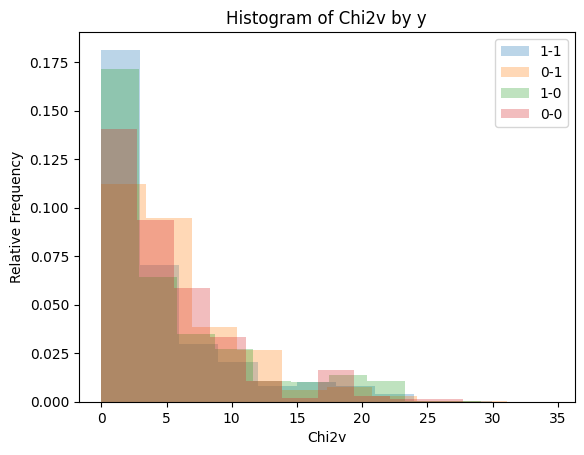

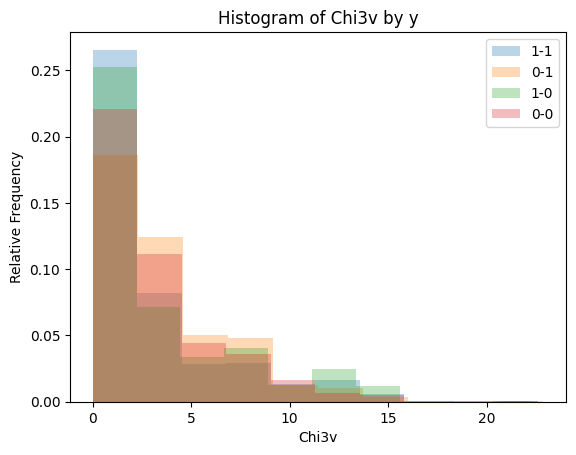

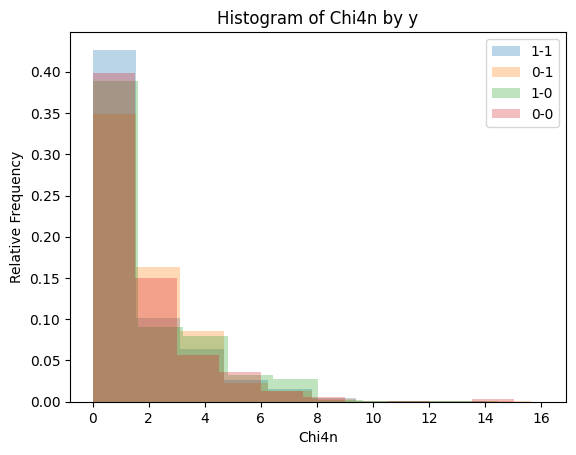

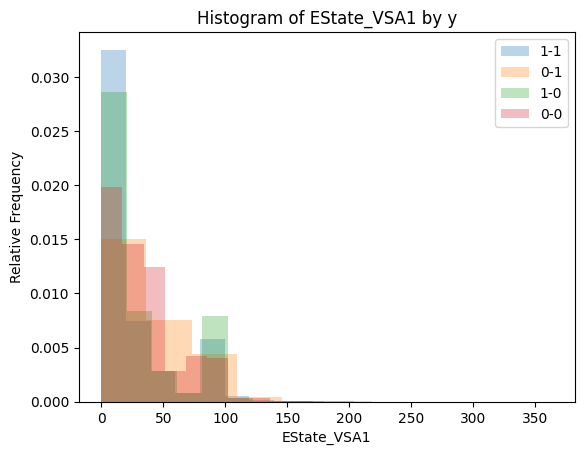

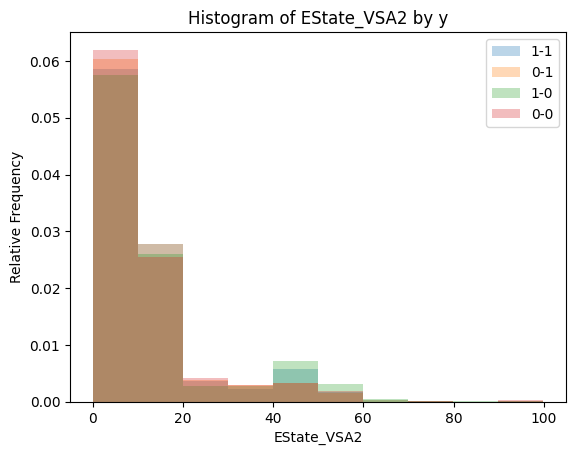

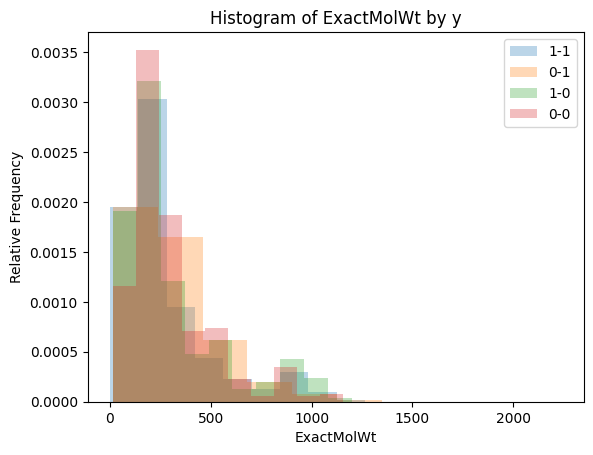

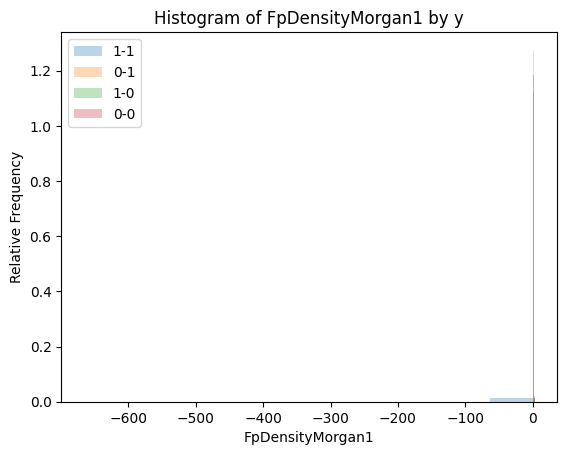

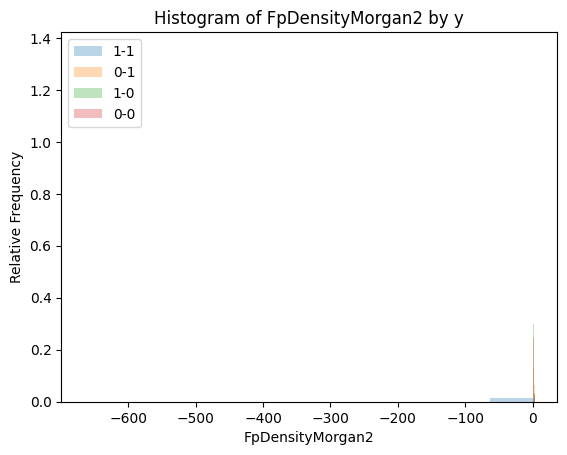

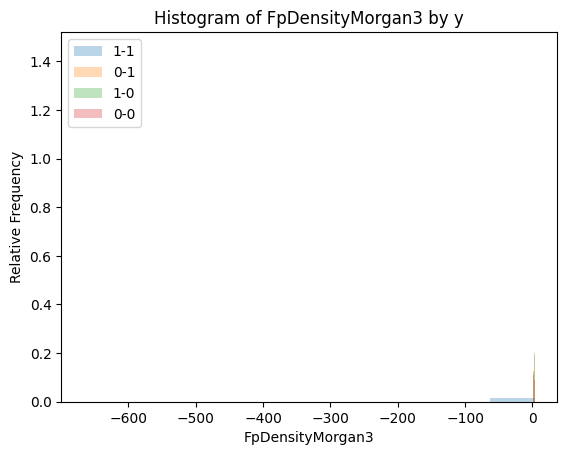

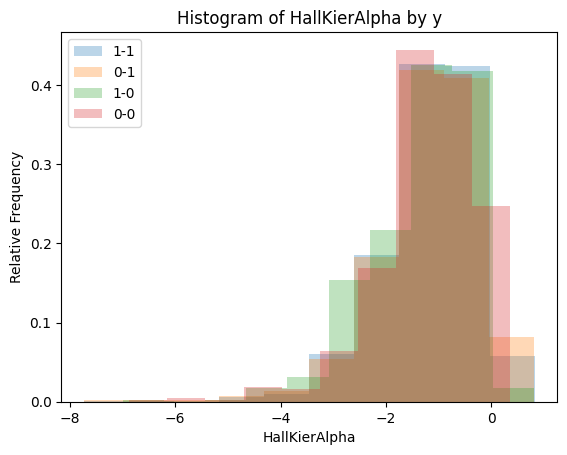

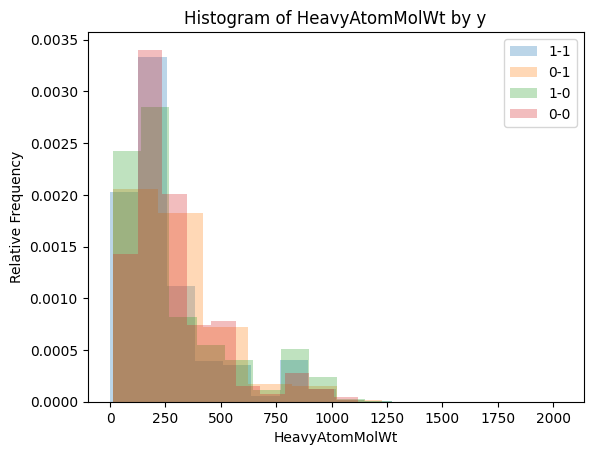

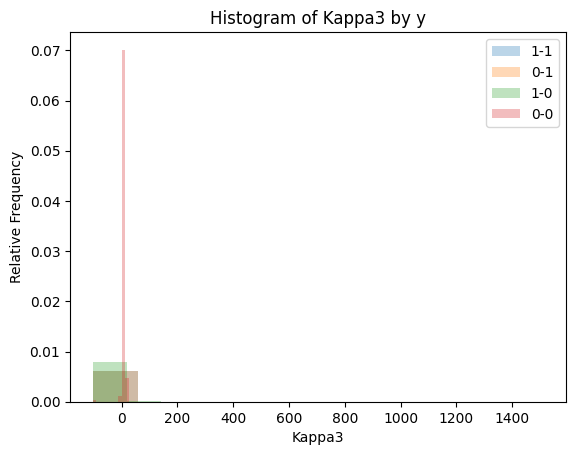

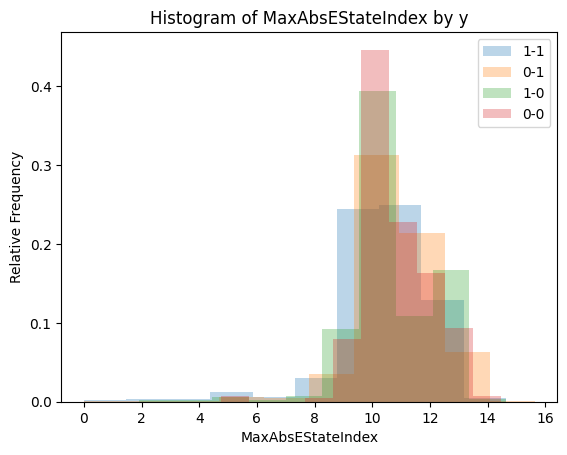

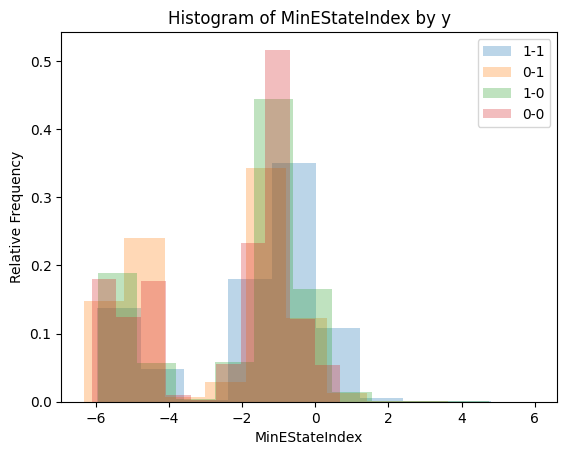

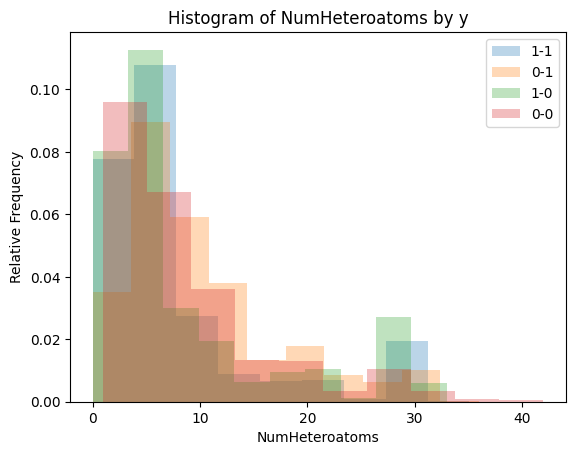

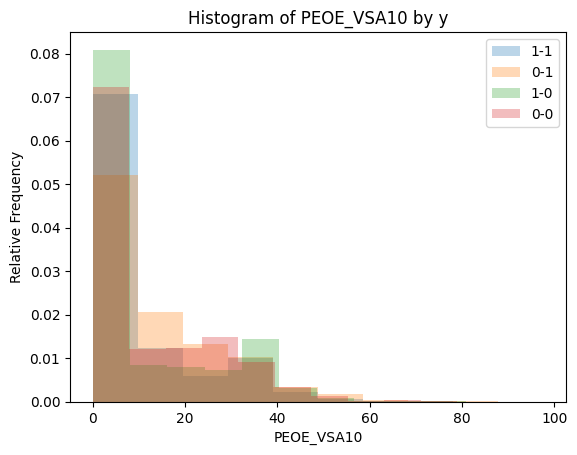

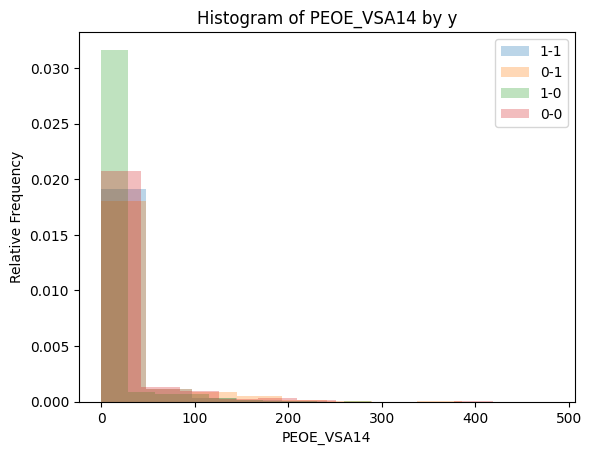

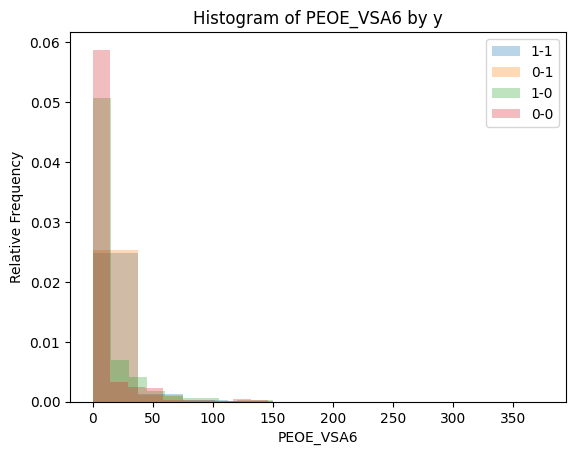

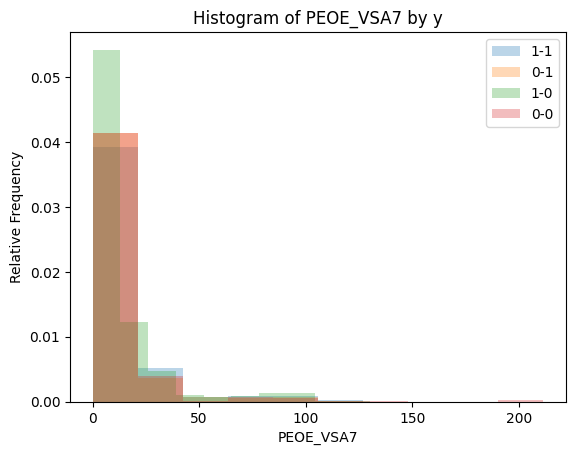

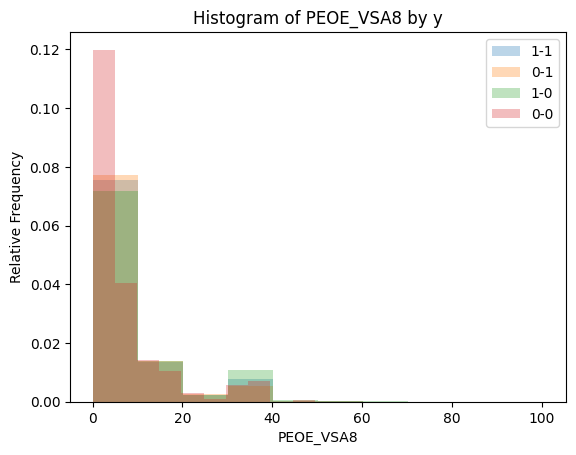

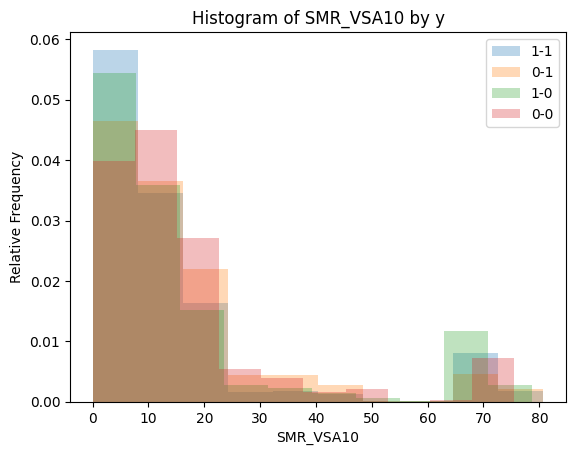

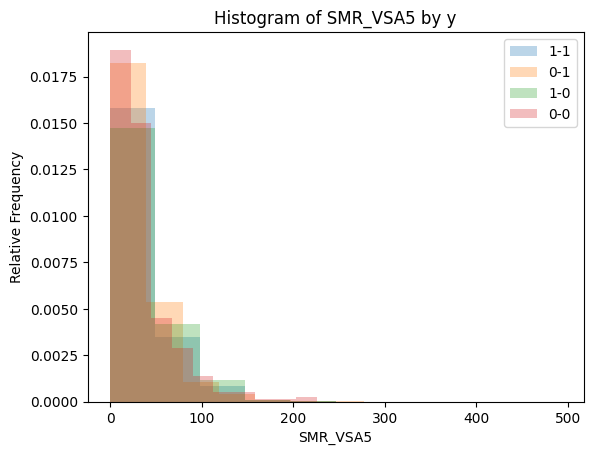

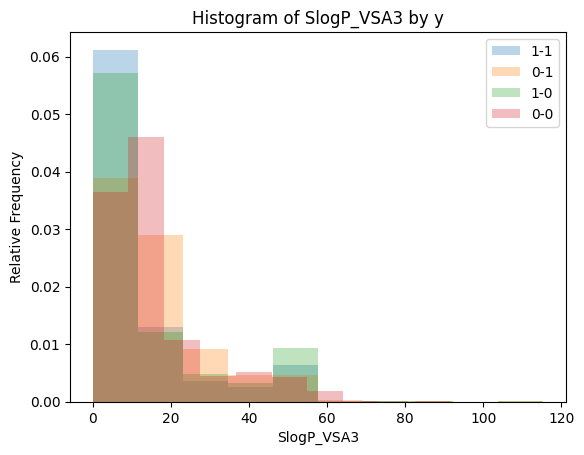

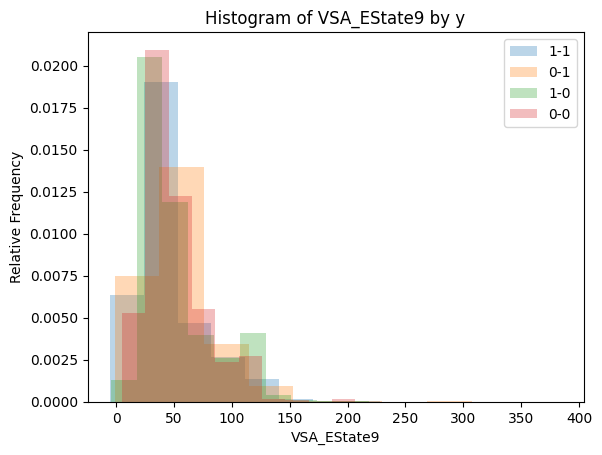

In [18]:
hist_bytarget(train_data, numerical_cols, 'y', density = True, alpha = 0.3)

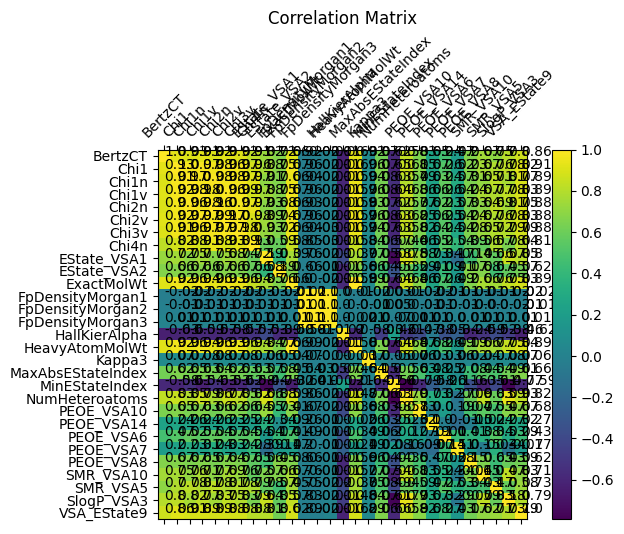

In [19]:
plot_corrmatrix(train_data, numerical_cols)

## Preprocessing <a id="preprocessing"></a>

[Return to Index](#index)

### Data Engineering

In [20]:
train_data = train_data.assign(
    # Many of the Surface Area columns have value 0. We'll make columns to indicate this
    EState_VSA1_is0 = lambda x: (x.EState_VSA1 == 0)*1,
    EState_VSA2_is0 = lambda x: (x.EState_VSA2 == 0)*1,
    PEOE_VSA10_is0 = lambda x: (x.PEOE_VSA10 == 0)*1,
    PEOE_VSA14_is0 = lambda x: (x.PEOE_VSA14 == 0)*1,
    PEOE_VSA6_is0 = lambda x: (x.PEOE_VSA6 == 0)*1,
    PEOE_VSA7_is0 = lambda x: (x.PEOE_VSA7 == 0)*1,
    PEOE_VSA8_is0 = lambda x: (x.PEOE_VSA8 == 0)*1,
    SMR_VSA10_is0 = lambda x: (x.SMR_VSA10 == 0)*1,
    SMR_VSA5_is0 = lambda x: (x.SMR_VSA5 == 0)*1,
    SlogP_VSA3_is0 = lambda x: (x.SlogP_VSA3 == 0)*1,
    
    # We'll Calculate LightAtomMolWt, and express it and HeavyAtomMolWt as ratios of ExactMolWt
    LightAtomMolWt = lambda x: x.ExactMolWt - x.HeavyAtomMolWt,
    HeavyAtomMolWtRatio = lambda x: x.HeavyAtomMolWt / x.ExactMolWt,
    LightAtomMolWtRatio = lambda x: x.LightAtomMolWt / x.ExactMolWt
)

### Selection of final columns

In [21]:
train_data.columns

Index(['id', 'BertzCT', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3v',
       'Chi4n', 'EState_VSA1', 'EState_VSA2', 'ExactMolWt', 'FpDensityMorgan1',
       'FpDensityMorgan2', 'FpDensityMorgan3', 'HallKierAlpha',
       'HeavyAtomMolWt', 'Kappa3', 'MaxAbsEStateIndex', 'MinEStateIndex',
       'NumHeteroatoms', 'PEOE_VSA10', 'PEOE_VSA14', 'PEOE_VSA6', 'PEOE_VSA7',
       'PEOE_VSA8', 'SMR_VSA10', 'SMR_VSA5', 'SlogP_VSA3', 'VSA_EState9',
       'fr_COO', 'fr_COO2', 'EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6', 'y',
       'EState_VSA1_is0', 'EState_VSA2_is0', 'PEOE_VSA10_is0',
       'PEOE_VSA14_is0', 'PEOE_VSA6_is0', 'PEOE_VSA7_is0', 'PEOE_VSA8_is0',
       'SMR_VSA10_is0', 'SMR_VSA5_is0', 'SlogP_VSA3_is0', 'LightAtomMolWt',
       'HeavyAtomMolWtRatio', 'LightAtomMolWtRatio'],
      dtype='object')

In [22]:
exclude_features = ['id', 'EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6', 'LightAtomMolWt', 'HeavyAtomMolWt', 'y']

categorical_features = [
    'EState_VSA1_is0', 'EState_VSA2_is0', 'PEOE_VSA10_is0', 'PEOE_VSA14_is0', 'PEOE_VSA6_is0', 
    'PEOE_VSA7_is0', 'PEOE_VSA8_is0', 'SMR_VSA10_is0', 'SMR_VSA5_is0', 'SlogP_VSA3_is0'
]

numerical_features = [col for col in train_data.columns if col not in exclude_features + categorical_features]

### Train-Test Split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    train_data[numerical_features + categorical_features],
    LabelEncoder().fit_transform(train_data['y']),
    random_state = 23,
    stratify = train_data['y']
)

## Model <a id="model"></a>

[Return to Index](#index)

CV Split

In [24]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 23)

### LinearSVC

In [45]:
lsvc_grid = {
    'lsvc__estimator__C':[1, 10, 100, 1000]
}

In [46]:
lsvc_estimator = Pipeline(
    [
        (
            'column_transformer',
            ColumnTransformer(
                [
                    (
                        'numeric',
                        Pipeline(
                            [
                                ('impute', SimpleImputer(strategy = 'mean')),
                                ('scale', StandardScaler())
                            ]
                        ),
                        numerical_features
                    ),
                    (
                        'categoric',
                        Pipeline(
                            [
                                ('impute', SimpleImputer(strategy = 'most_frequent')),
                                (
                                    'encode', OneHotEncoder(
                                        handle_unknown = 'ignore', sparse_output = False, drop = 'if_binary'
                                    )
                                )
                            ]
                        ),
                        categorical_features
                    )
                ]
            )
        ),
        (
            'lsvc',
            CalibratedClassifierCV(
                LinearSVC(random_state = 23, class_weight = 'balanced', max_iter = 1000), 
                cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 23)
            )
        )
    ]
)

In [49]:
lsvc = GridSearchCV(
    lsvc_estimator,
    param_grid = lsvc_grid,
    scoring = 'roc_auc_ovr',
    cv = cv,
    refit = True,
    n_jobs = -1
)

In [50]:
lsvc.fit(X_train, y_train)

C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e18-GM_jbEwk-py3.9\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e18-GM_jbEwk-py3.9\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e18-GM_jbEwk-py3.9\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e18-GM_jbEwk-py3.9\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=23, shuffle=True),
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer()),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['BertzCT',
                                                                          'Chi1',
                                                                          'Chi1n',
                                                                          'Chi1v',
                                                                          'Chi2n',
                                                                          'Chi2v',
                                                                          'Chi3v',
                                                                          'Chi4n',
                                                                          'EState_VSA1',
                                                                          'EState_VSA2',
                                                                          'ExactMolWt',
                                                                          'FpDens...
                                                                          'PEOE_VSA14_is0',
                                                                          'PEOE_VSA6_is0',
                                                                          'PEOE_VSA7_is0',
                                                                          'PEOE_VSA8_is0',
                                                                          'SMR_VSA10_is0',
                                                                          'SMR_VSA5_is0',
                                                                          'SlogP_VSA3_is0'])])),
                                       ('lsvc',
                                        CalibratedClassifierCV(cv=StratifiedKFold(n_splits=5, random_state=23, shuffle=True),
                                                               estimator=LinearSVC(class_weight='balanced',
                                                                                   random_state=23)))]),
             n_jobs=-1, param_grid={'lsvc__estimator__C': [1, 10, 100, 1000]},
             scoring='roc_auc_ovr')

In [51]:
lsvc_best_params = {key.split('__')[-1]: value for key, value in lsvc.best_params_.items()}
print(lsvc_best_params)

{'C': 1}


In [52]:
best_lsvc = lsvc.best_estimator_

ROC AUC

In [53]:
roc_auc_score(y_test, best_lsvc.predict_proba(X_test), multi_class = 'ovr')

0.6138128245955732

### LightGBM <a id="lightgbm"></a>

In [54]:
lgbm_grid = [
    {
        'lgbm__max_depth': [-1],
        'lgbm__num_leaves': [50, 75, 100],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.1],
        'lgbm__n_estimators': [50, 70, 100]
    },
    {
        'lgbm__max_depth': [3],
        'lgbm__num_leaves': [10, 20, 30],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.1],
        'lgbm__n_estimators': [50, 70, 100]
    },
    {
        'lgbm__max_depth': [5],
        'lgbm__num_leaves': [20, 30, 40],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.1],
        'lgbm__n_estimators': [50, 70, 100]
    },
    {
        'lgbm__max_depth': [7],
        'lgbm__num_leaves': [30, 40, 50],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.1],
        'lgbm__n_estimators': [50, 70, 100]
    },
    {
        'lgbm__max_depth': [-1],
        'lgbm__num_leaves': [50, 75, 100],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.05],
        'lgbm__n_estimators': [70, 100, 120]
    },
    {
        'lgbm__max_depth': [3],
        'lgbm__num_leaves': [10, 20, 30],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.05],
        'lgbm__n_estimators': [70, 100, 120]
    },
    {
        'lgbm__max_depth': [5],
        'lgbm__num_leaves': [20, 30, 40],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.05],
        'lgbm__n_estimators': [70, 100, 120]
    },
    {
        'lgbm__max_depth': [7],
        'lgbm__num_leaves': [30, 40, 50],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.05],
        'lgbm__n_estimators': [70, 100, 120]
    },
    {
        'lgbm__max_depth': [-1],
        'lgbm__num_leaves': [50, 75, 100],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.1],
        'lgbm__n_estimators': [50, 70, 100]
    },
    {
        'lgbm__max_depth': [3],
        'lgbm__num_leaves': [10, 20, 30],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.01],
        'lgbm__n_estimators': [100, 120, 150]
    },
    {
        'lgbm__max_depth': [5],
        'lgbm__num_leaves': [20, 30, 40],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.01],
        'lgbm__n_estimators': [100, 120, 150]
    },
    {
        'lgbm__max_depth': [7],
        'lgbm__num_leaves': [30, 40, 50],
        'lgbm__subsample': [0.5, 0.7, 1],
        'lgbm__colsample_bytree': [0.6, 0.8, 1],
        'lgbm__max_bin': [150, 200, 255],
        'lgbm__learning_rate': [0.01],
        'lgbm__n_estimators': [100, 120, 150]
    },
]

In [55]:
lgbm_estimator = Pipeline(
    [
        (
            'column_transformer',
            ColumnTransformer(
                [
                    (
                        'numeric',
                        Pipeline(
                            [
                                ('impute', SimpleImputer(strategy = 'mean')),
                                ('scale', StandardScaler())
                            ]
                        ),
                        numerical_features
                    ),
                    (
                        'categoric',
                        Pipeline(
                            [
                                ('impute', SimpleImputer(strategy = 'most_frequent')),
                                (
                                    'encode', OrdinalEncoder(
                                        handle_unknown = 'use_encoded_value',
                                        unknown_value = -1
                                    )
                                )
                            ]
                        ),
                        categorical_features
                    )
                ]
            )
        ),
        (
            'lgbm',
            lgb.LGBMClassifier(random_state = 23, is_unbalance = True)
        )
    ]
)

In [56]:
lgbm = RandomizedSearchCV(
    lgbm_estimator,
    n_iter = 50,
    param_distributions = lgbm_grid,
    scoring = 'roc_auc_ovr',
    cv = cv,
    random_state = 23,
    refit = True,
    n_jobs = -1
)

In [57]:
lgbm.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=23, shuffle=True),
                   estimator=Pipeline(steps=[('column_transformer',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer()),
                                                                                               ('scale',
                                                                                                StandardScaler())]),
                                                                               ['BertzCT',
                                                                                'Chi1',
                                                                                'Chi1n',
                                                                                'Chi1v',
                                                                                'Chi2n',
                                                                                'Chi2v',
                                                                                'Chi3v',
                                                                                'Chi4n',
                                                                                'EState_VSA1',
                                                                                'EState_VSA2',
                                                                                'ExactMolWt',
                                                                                '...
                                         'lgbm__n_estimators': [100, 120, 150],
                                         'lgbm__num_leaves': [20, 30, 40],
                                         'lgbm__subsample': [0.5, 0.7, 1]},
                                        {'lgbm__colsample_bytree': [0.6, 0.8,
                                                                    1],
                                         'lgbm__learning_rate': [0.01],
                                         'lgbm__max_bin': [150, 200, 255],
                                         'lgbm__max_depth': [7],
                                         'lgbm__n_estimators': [100, 120, 150],
                                         'lgbm__num_leaves': [30, 40, 50],
                                         'lgbm__subsample': [0.5, 0.7, 1]}],
                   random_state=23, scoring='roc_auc_ovr')

In [58]:
lgbm_best_params = {key.split('__')[-1]: value for key, value in lgbm.best_params_.items()}
print(lgbm_best_params)

{'subsample': 0.7, 'num_leaves': 20, 'n_estimators': 70, 'max_depth': 3, 'max_bin': 255, 'learning_rate': 0.05, 'colsample_bytree': 0.6}


In [59]:
best_lgbm = lgbm.best_estimator_

ROC AUC

In [60]:
roc_auc_score(y_test, best_lgbm.predict_proba(X_test), multi_class = 'ovr')

0.6447638977711757

### MLP

[Back to Model](#model)

In [61]:
def mlp_multiclass_classification_make_model(
    features_shape = 1,
    target_shape = 2,
    n_layers = 1,
    layer_size = 16,
    dropout = 0.0,
    output_bias = None,
    learning_rate = 0.01,
    metrics = ['accuracy'] # [mods.METRICS]
):
    # Initialize Inputs
    inputs = tf.keras.Input(shape = (features_shape,))
    
    # Dense layers
    for i in range(n_layers):
        if i == 0:
            x = tf.keras.layers.Dense(layer_size, activation = 'relu')(inputs)
            x = tf.keras.layers.Dropout(dropout)(x)
            
        else:
            x = tf.keras.layers.Dense(layer_size, activation = 'relu')(x)
            x = tf.keras.layers.Dropout(dropout)(x)
            
    # Initialize bias
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    else:
        output_bias = 'zeros'  
    
    # Final layer
    if n_layers == 0:
        outputs = tf.keras.layers.Dense(target_shape, activation = 'softmax', bias_initializer = output_bias)(inputs)
    
    else:
        outputs = tf.keras.layers.Dense(target_shape, activation = 'softmax', bias_initializer = output_bias)(x)
        
    # Initialize model
    model = tf.keras.Model(inputs, outputs)
    
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    
    # Compile model
    model.compile(
        loss = 'sparse_categorical_crossentropy', 
        optimizer = optimizer, 
        metrics = metrics
    )
    
    return model

In [62]:
mlp_grid = {
    'mlp__n_layers': [1, 3, 5, 7],
    'mlp__layer_size': [16, 32],
    'mlp__dropout': [0.2, 0.5],
    'mlp__learning_rate': [0.05, 0.01],
    'mlp__epochs': [3, 5, 10]
}

In [63]:
mlp_estimator = Pipeline(
    [
        (
            'column_transformer',
            ColumnTransformer(
                [
                    (
                        'numeric',
                        Pipeline(
                            [
                                ('inpute', SimpleImputer(strategy = 'mean')),
                                ('scale', MinMaxScaler())
                            ]
                        ),
                        numerical_features
                    ),
                    (
                        'categoric',
                        Pipeline(
                            [
                                ('impute', SimpleImputer(strategy = 'most_frequent')),
                                ('encode', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False, drop = 'if_binary'))
                            ]
                        ),
                        categorical_features
                    )
                ]
            )
        ),
        (
            'mlp',
            KerasClassifier(
                build_fn = mlp_multiclass_classification_make_model, 
                features_shape = 42,
                target_shape = 4,
                n_layers = None,
                layer_size = None,
                dropout = None,
                learning_rate = None,
                verbose = True, 
                random_state = 23)
        )
    ]
)

In [64]:
mlp = RandomizedSearchCV(
    mlp_estimator,
    n_iter = 25,
    param_distributions = mlp_grid,
    random_state = 23,
    scoring = 'roc_auc_ovr',
    cv = cv,
    refit = True,
    n_jobs = -1
)

In [65]:
class_weights = {
    label: weight for label, weight in zip(
        np.unique(y_train), 
        compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)
    )
}

In [66]:
mlp.fit(X_train, y_train, mlp__batch_size = 32, mlp__class_weight = class_weights)

Epoch 1/5


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e18-GM_jbEwk-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


348/348 [==============================] - 1s 873us/step - loss: 1.3623 - accuracy: 0.3149
Epoch 2/5
348/348 [==============================] - 0s 835us/step - loss: 1.3536 - accuracy: 0.3098
Epoch 3/5
348/348 [==============================] - 0s 844us/step - loss: 1.3519 - accuracy: 0.3006
Epoch 4/5
348/348 [==============================] - 0s 814us/step - loss: 1.3486 - accuracy: 0.3008
Epoch 5/5
348/348 [==============================] - 0s 827us/step - loss: 1.3470 - accuracy: 0.2967


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=23, shuffle=True),
                   estimator=Pipeline(steps=[('column_transformer',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('inpute',
                                                                                                SimpleImputer()),
                                                                                               ('scale',
                                                                                                MinMaxScaler())]),
                                                                               ['BertzCT',
                                                                                'Chi1',
                                                                                'Chi1n',
                                                                                'Chi1v',
                                                                                'Chi2n',
                                                                                'Chi2v',
                                                                                'Chi3v',
                                                                                'Chi4n',
                                                                                'EState_VSA1',
                                                                                'EState_VSA2',
                                                                                'ExactMolWt',
                                                                                'Fp...
                                              KerasClassifier(build_fn=<function mlp_multiclass_classification_make_model at 0x00000241F1C750D0>, dropout=None, features_shape=42, layer_size=None, learning_rate=None, n_layers=None, random_state=23, target_shape=4, verbose=True))]),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'mlp__dropout': [0.2, 0.5],
                                        'mlp__epochs': [3, 5, 10],
                                        'mlp__layer_size': [16, 32],
                                        'mlp__learning_rate': [0.05, 0.01],
                                        'mlp__n_layers': [1, 3, 5, 7]},
                   random_state=23, scoring='roc_auc_ovr')

In [67]:
mlp_best_params = {key.split('__')[-1]: value for key, value in mlp.best_params_.items()}
print(mlp_best_params)

{'n_layers': 1, 'learning_rate': 0.01, 'layer_size': 32, 'epochs': 5, 'dropout': 0.2}


In [68]:
best_mlp = mlp.best_estimator_

ROC AUC

In [69]:
roc_auc_score(y_test, best_mlp.predict_proba(X_test), multi_class = 'ovr')

116/116 [==============================] - 0s 557us/step


0.6288524495053496

### Final Model <a id="finalmodel"></a>

[Back to Model](#model)

In [70]:
final_model = StackingClassifier(
    estimators = [
        (
            'LinearSVC',
            Pipeline(
                [
                    (
                        'column_transformer',
                        ColumnTransformer(
                            [
                                (
                                    'numeric',
                                    Pipeline(
                                        [
                                            ('impute', SimpleImputer(strategy = 'mean')),
                                            ('scale', StandardScaler())
                                        ]
                                    ),
                                    numerical_features
                                ),
                                (
                                    'categoric',
                                    Pipeline(
                                        [
                                            ('impute', SimpleImputer(strategy = 'most_frequent')),
                                            (
                                                'encode', OneHotEncoder(
                                                    handle_unknown = 'ignore', sparse_output = False, drop = 'if_binary'
                                                )
                                            )
                                        ]
                                    ),
                                    categorical_features
                                )
                            ]
                        )
                    ),
                    (
                        'lsvc',
                        CalibratedClassifierCV(
                            LinearSVC(random_state = 23, class_weight = 'balanced', max_iter = 5000, **lsvc_best_params), 
                            cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
                        )
                    )
                ]
            )
        ),
        (
            'LightGBM',
            Pipeline(
                [
                    (
                        'column_transformer',
                        ColumnTransformer(
                            [
                                (
                                    'numeric',
                                    Pipeline(
                                        [
                                            ('impute', SimpleImputer(strategy = 'mean')),
                                            ('scale', StandardScaler())
                                        ]
                                    ),
                                    numerical_features
                                ),
                                (
                                    'categoric',
                                    Pipeline(
                                        [
                                            ('impute', SimpleImputer(strategy = 'most_frequent')),
                                            (
                                                'encode', OrdinalEncoder(
                                                    handle_unknown = 'use_encoded_value',
                                                    unknown_value = -1
                                                )
                                            )
                                        ]
                                    ),
                                    categorical_features
                                )
                            ]
                        )
                    ),
                    (
                        'lgbm',
                        lgb.LGBMClassifier(random_state = 42, is_unbalance = True, **lgbm_best_params)
                    )
                ]
            )
        ),
        (
            'MLP',
            Pipeline(
                [
                    (
                        'column_transformer',
                        ColumnTransformer(
                            [
                                (
                                    'numeric',
                                    Pipeline(
                                        [
                                            ('inpute', SimpleImputer(strategy = 'mean')),
                                            ('scale', MinMaxScaler())
                                        ]
                                    ),
                                    numerical_features
                                ),
                                (
                                    'categoric',
                                    Pipeline(
                                        [
                                            ('impute', SimpleImputer(strategy = 'most_frequent')),
                                            ('encode', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False, drop = 'if_binary'))
                                        ]
                                    ),
                                    categorical_features
                                )
                            ]
                        )
                    ),
                    (
                        'mlp',
                        KerasClassifier(
                            build_fn = mlp_multiclass_classification_make_model, 
                            features_shape = 42,
                            target_shape = 4,
                            verbose = True, 
                            random_state = 42,
                            class_weight = class_weights,
                            batch_size = 32,
                            **mlp_best_params
                        )
                    )
                ]
            )
        )
    ],
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42),
    n_jobs = -1
)

In [71]:
final_model.fit(X_train, y_train)

C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e18-GM_jbEwk-py3.9\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e18-GM_jbEwk-py3.9\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e18-GM_jbEwk-py3.9\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e18-GM_jbEwk-py3.9\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\

Epoch 1/5
348/348 [==============================] - 1s 814us/step - loss: 1.3667 - accuracy: 0.3057
Epoch 2/5
348/348 [==============================] - 0s 822us/step - loss: 1.3544 - accuracy: 0.3419
Epoch 3/5
348/348 [==============================] - 0s 832us/step - loss: 1.3511 - accuracy: 0.3017
Epoch 4/5
348/348 [==============================] - 0s 814us/step - loss: 1.3498 - accuracy: 0.2927
Epoch 5/5
348/348 [==============================] - 0s 827us/step - loss: 1.3475 - accuracy: 0.3217


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e18-GM_jbEwk-py3.9\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e18-GM_jbEwk-py3.9\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e18-GM_jbEwk-py3.9\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e18-GM_jbEwk-py3.9\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\

Epoch 1/5
279/279 [==============================] - 1s 800us/step - loss: 1.3675 - accuracy: 0.3303
Epoch 2/5
279/279 [==============================] - 0s 876us/step - loss: 1.3493 - accuracy: 0.3532
Epoch 3/5
279/279 [==============================] - 0s 852us/step - loss: 1.3508 - accuracy: 0.3591
Epoch 4/5
279/279 [==============================] - 0s 854us/step - loss: 1.3453 - accuracy: 0.3363
Epoch 5/5
70/70 [==============================] - 0s 569us/step


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e18-GM_jbEwk-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
279/279 [==============================] - 1s 818us/step - loss: 1.3641 - accuracy: 0.3193
Epoch 2/5
279/279 [==============================] - 0s 793us/step - loss: 1.3527 - accuracy: 0.3713
Epoch 3/5
279/279 [==============================] - 0s 818us/step - loss: 1.3470 - accuracy: 0.3353
Epoch 4/5
279/279 [==============================] - 0s 795us/step - loss: 1.3444 - accuracy: 0.3295
Epoch 5/5
70/70 [==============================] - 0s 540us/step


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e18-GM_jbEwk-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
279/279 [==============================] - 1s 802us/step - loss: 1.3668 - accuracy: 0.3496
Epoch 2/5
279/279 [==============================] - 0s 764us/step - loss: 1.3556 - accuracy: 0.3351
Epoch 3/5
279/279 [==============================] - 0s 823us/step - loss: 1.3515 - accuracy: 0.3006
Epoch 4/5
279/279 [==============================] - 0s 798us/step - loss: 1.3533 - accuracy: 0.3164
Epoch 5/5
70/70 [==============================] - 0s 524us/step


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e18-GM_jbEwk-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
279/279 [==============================] - 1s 791us/step - loss: 1.3672 - accuracy: 0.2963
Epoch 2/5
279/279 [==============================] - 0s 857us/step - loss: 1.3534 - accuracy: 0.3418
Epoch 3/5
279/279 [==============================] - 0s 851us/step - loss: 1.3532 - accuracy: 0.3411
Epoch 4/5
279/279 [==============================] - 0s 870us/step - loss: 1.3474 - accuracy: 0.3003
Epoch 5/5
70/70 [==============================] - 0s 566us/step


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e18-GM_jbEwk-py3.9\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
279/279 [==============================] - 1s 803us/step - loss: 1.3659 - accuracy: 0.3361
Epoch 2/5
279/279 [==============================] - 0s 795us/step - loss: 1.3562 - accuracy: 0.3161
Epoch 3/5
279/279 [==============================] - 0s 777us/step - loss: 1.3543 - accuracy: 0.3210
Epoch 4/5
279/279 [==============================] - 0s 803us/step - loss: 1.3500 - accuracy: 0.3200
Epoch 5/5
70/70 [==============================] - 0s 533us/step


C:\Users\jorge\AppData\Local\pypoetry\Cache\virtualenvs\playground-s03e18-GM_jbEwk-py3.9\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimators=[('LinearSVC',
                                Pipeline(steps=[('column_transformer',
                                                 ColumnTransformer(transformers=[('numeric',
                                                                                  Pipeline(steps=[('impute',
                                                                                                   SimpleImputer()),
                                                                                                  ('scale',
                                                                                                   StandardScaler())]),
                                                                                  ['BertzCT',
                                                                                   'Chi1',
                                                                                   'Chi1n',
                                                                                   'Chi1v',
                                                                                   'Chi2n',
                                                                                   'Chi2v',
                                                                                   'Chi3v',
                                                                                   'Chi4n',
                                                                                   'EState_VSA1',
                                                                                   'EState_VSA2'...
                                                ('mlp',
                                                 KerasClassifier(batch_size=32, build_fn=<function mlp_multiclass_classification_make_model at 0x00000241F1C750D0>, class_weight={0: 6.3807339449541285, 1: 0.8531125421649801, 2: 1.5446973903387007, 3: 0.49413854351687386}, dropout=0.2, epochs=5, features_shape=42, layer_size=32, learning_rate=0.01, n_layers=1, random_state=42, target_shape=4, verbose=True))]))])

### Evaluate Model <a id="evaluate"></a>

[Back to Model](#model)

### Save Predictions <a id="savepreds"></a>

[Back to Model](#model)

In [72]:
test_data

,id,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,...,PEOE_VSA14,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2
0,14838,344.632371,7.283603,4.473966,5.834958,3.412257,4.651530,2.096558,1.116433,49.458581,...,13.512441,0.000000,0.000000,0.000000,26.809272,24.539800,4.794537,47.304082,1,1
1,14839,1432.410201,10.663869,7.079026,8.065215,5.297097,5.297097,3.924155,2.569694,0.000000,...,0.000000,34.947374,98.323987,9.606882,0.000000,53.378235,0.000000,43.166667,0,0
2,14840,83.352608,3.931852,1.774215,1.774215,1.073446,1.073446,0.467830,0.170838,5.969305,...,5.969305,0.000000,0.000000,6.420822,11.752550,13.344559,9.589074,24.666667,1,1
3,14841,150.255712,5.912790,3.548812,3.548812,2.595128,2.595128,1.642813,0.694113,0.000000,...,59.935299,0.000000,0.000000,0.000000,17.744066,32.290168,4.794537,26.778866,0,0
4,14842,1817.276351,24.910940,15.540529,20.047314,12.535886,17.730988,11.979618,4.431173,84.554972,...,23.468091,25.609359,0.000000,37.099000,69.141353,38.704130,50.697492,102.583333,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9888,24726,246.422865,4.036581,2.816709,2.816709,1.875634,1.875634,1.235986,0.362743,24.146543,...,11.938611,0.000000,0.000000,0.000000,11.938611,12.207933,9.589074,30.000000,2,2
9889,24727,591.069706,8.770857,5.682461,5.682461,4.050440,4.050440,2.167855,1.770579,0.000000,...,0.000000,18.199101,37.107112,17.696186,10.969244,0.000000,0.000000,53.166667,0,0
9890,24728,378.113435,6.310349,3.402334,4.317724,2.817428,4.071978,1.970236,1.165747,36.705949,...,7.822697,0.000000,0.000000,0.000000,7.822697,24.099010,4.736863,50.652870,0,0
9891,24729,737.653518,9.949161,7.337949,7.337949,4.428511,5.948361,3.972459,2.160881,36.992053,...,0.000000,0.000000,0.000000,6.196844,0.000000,12.462662,9.589074,50.250000,0,0


In [73]:
X = test_data.assign(
    # Many of the Surface Area columns have value 0. We'll make columns to indicate this
    EState_VSA1_is0 = lambda x: (x.EState_VSA1 == 0)*1,
    EState_VSA2_is0 = lambda x: (x.EState_VSA2 == 0)*1,
    PEOE_VSA10_is0 = lambda x: (x.PEOE_VSA10 == 0)*1,
    PEOE_VSA14_is0 = lambda x: (x.PEOE_VSA14 == 0)*1,
    PEOE_VSA6_is0 = lambda x: (x.PEOE_VSA6 == 0)*1,
    PEOE_VSA7_is0 = lambda x: (x.PEOE_VSA7 == 0)*1,
    PEOE_VSA8_is0 = lambda x: (x.PEOE_VSA8 == 0)*1,
    SMR_VSA10_is0 = lambda x: (x.SMR_VSA10 == 0)*1,
    SMR_VSA5_is0 = lambda x: (x.SMR_VSA5 == 0)*1,
    SlogP_VSA3_is0 = lambda x: (x.SlogP_VSA3 == 0)*1,
    
    # We'll Calculate LightAtomMolWt, and express it and HeavyAtomMolWt as ratios of ExactMolWt
    LightAtomMolWt = lambda x: x.ExactMolWt - x.HeavyAtomMolWt,
    HeavyAtomMolWtRatio = lambda x: x.HeavyAtomMolWt / x.ExactMolWt,
    LightAtomMolWtRatio = lambda x: x.LightAtomMolWt / x.ExactMolWt
)[numerical_features + categorical_features]

In [74]:
y = final_model.predict_proba(X)

310/310 [==============================] - 0s 501us/step


In [75]:
prediction = pd.DataFrame(
    {
        'id': test_data['id'],
        'EC1': y[:, 2] + y[:, 3],
        'EC2': y[:, 1] + y[:, 3]
    }
)

In [76]:
prediction.to_csv('predictions/prediction.csv', index = False)